In [9]:
GROQ_API_KEY = "API KEY"

In [10]:
! pip install pydantic-ai
! pip install langgraph

/usr/lib/python3.12/pathlib.py:407: RuntimeWarning: coroutine 'AbstractAgent.run' was never awaited
  def _load_parts(self):


In [11]:
from pydantic_ai import Agent
from pydantic_ai.models.groq import GroqModel
from pydantic_ai.providers.groq import GroqProvider

model = GroqModel(
    'llama-3.3-70b-versatile', provider=GroqProvider(api_key=GROQ_API_KEY)
)
agent = Agent(model)

In [13]:
import nest_asyncio

nest_asyncio.apply()

In [14]:
agent.run_sync("Hi")

AgentRunResult(output="It's nice to meet you. Is there something I can help you with or would you like to chat?")

In [15]:
import pandas as pd

In [16]:
auto_sales_df = pd.read_csv("Auto Sales data.csv")
auto_sales_df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,DAYS_SINCE_LASTORDER,STATUS,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,CITY,POSTALCODE,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,24/02/2018,828,Shipped,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,10022,USA,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,07/05/2018,757,Shipped,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,51100,France,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,01/07/2018,703,Shipped,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Paris,75508,France,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,25/08/2018,649,Shipped,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,Pasadena,90003,USA,Young,Julie,Medium
4,10168,36,96.66,1,3479.76,28/10/2018,586,Shipped,Motorcycles,95,S10_1678,Technics Stores Inc.,6505556809,9408 Furth Circle,Burlingame,94217,USA,Hirano,Juri,Medium


In [17]:
auto_sales_df.shape

(2747, 20)

In [18]:
auto_sales_df.columns

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'ORDERDATE', 'DAYS_SINCE_LASTORDER', 'STATUS', 'PRODUCTLINE',
       'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE', 'ADDRESSLINE1', 'CITY',
       'POSTALCODE', 'COUNTRY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
       'DEALSIZE'],
      dtype='object')

In [24]:
print(auto_sales_df.to_xml(index=False))

<?xml version='1.0' encoding='utf-8'?>
<data>
  <row>
    <ORDERNUMBER>10107</ORDERNUMBER>
    <QUANTITYORDERED>30</QUANTITYORDERED>
    <PRICEEACH>95.7</PRICEEACH>
    <ORDERLINENUMBER>2</ORDERLINENUMBER>
    <SALES>2871.0</SALES>
    <ORDERDATE>24/02/2018</ORDERDATE>
    <DAYS_SINCE_LASTORDER>828</DAYS_SINCE_LASTORDER>
    <STATUS>Shipped</STATUS>
    <PRODUCTLINE>Motorcycles</PRODUCTLINE>
    <MSRP>95</MSRP>
    <PRODUCTCODE>S10_1678</PRODUCTCODE>
    <CUSTOMERNAME>Land of Toys Inc.</CUSTOMERNAME>
    <PHONE>2125557818</PHONE>
    <ADDRESSLINE1>897 Long Airport Avenue</ADDRESSLINE1>
    <CITY>NYC</CITY>
    <POSTALCODE>10022</POSTALCODE>
    <COUNTRY>USA</COUNTRY>
    <CONTACTLASTNAME>Yu</CONTACTLASTNAME>
    <CONTACTFIRSTNAME>Kwai</CONTACTFIRSTNAME>
    <DEALSIZE>Small</DEALSIZE>
  </row>
  <row>
    <ORDERNUMBER>10121</ORDERNUMBER>
    <QUANTITYORDERED>34</QUANTITYORDERED>
    <PRICEEACH>81.35</PRICEEACH>
    <ORDERLINENUMBER>5</ORDERLINENUMBER>
    <SALES>2765.9</SALES>
    <ORDE

In [87]:
data_analyst_agent = Agent(model,
                           system_prompt='''
                           You are data analyst agent,Who will answer the data analysis related question according to provided data.
                           You will generate a python code using pandas to derive the answer to the question if needed.
                           You can assume the data in available as pandas data frame in a variable called `df`.
                           Do not return anything other than python code to product results.
                           '''
                           )

@data_analyst_agent.system_prompt
def system_prompt():
    sp = f'''
    Follwing is the example data in dataframe `df` in XML format:
    {auto_sales_df.head(10).to_xml(index=False)}
    '''
    return sp

In [54]:
response = data_analyst_agent.run_sync("What is the total sales from USA?")

In [58]:
code = response.output.replace("```python", "").replace('```', "")
print(code)


# Filter the sales from USA and calculate the total
total_sales_usa = df[df['COUNTRY'] == 'USA']['SALES'].sum()

print(f'Total sales from USA: {total_sales_usa}')



In [60]:
df = auto_sales_df
exec(code)

Total sales from USA: 3355575.6900000004


In [84]:
format_agent = Agent(model,
                     system_prompt='''Format the follwing answer to question''',
                     )

In [62]:
from typing import TypedDict

class AnalysisState(TypedDict):
    df: pd.DataFrame
    question: str
    answer: str
    code: str
    code_output: str

In [73]:
def code_generator(state: AnalysisState)-> AnalysisState:
    response = data_analyst_agent.run_sync(state["question"])
    code = response.output.replace("```python", "").replace('```', "")
    state["code"] =  code
    return state

In [74]:
def execute_code(state: AnalysisState)-> AnalysisState:
    import sys
    import io

    # Store the original stdout
    original_stdout = sys.stdout
    captured_output = io.StringIO()

    # Redirect stdout to the StringIO object
    sys.stdout = captured_output
    exec(state["code"])
    sys.stdout = original_stdout
    state["code_output"] = captured_output.getvalue()

    return state

In [92]:
def format_answer(state: AnalysisState)-> AnalysisState:

    response = format_agent.run_sync(
        f"Question : {state['question']} \n Answer : {state['code_output']}"
    )

    state["answer"] = response.output

    return state

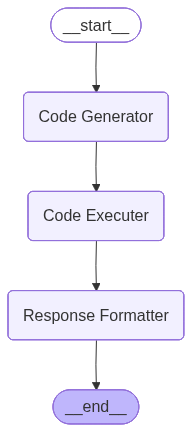

In [93]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(AnalysisState)

graph_builder.add_node("Code Generator", code_generator)
graph_builder.add_node("Code Executer", execute_code)
graph_builder.add_node("Response Formatter", format_answer)


graph_builder.add_edge(START, "Code Generator")
graph_builder.add_edge("Code Generator", "Code Executer")
graph_builder.add_edge("Code Executer", "Response Formatter")
graph_builder.add_edge("Response Formatter", END)


graph = graph_builder.compile()


from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [96]:
state = AnalysisState(
    df=auto_sales_df,
    question="What is the total sales from USA?",
    answer=None,
    code=None,
    code_output=None
)

output_state = graph.invoke(state)
print(output_state["answer"])

**Total Sales from USA:** 
The total sales from the USA is: **$3,355,575.69**
